<a href="https://colab.research.google.com/github/ahmadryan/MLTSAProject/blob/master/RNN_network_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from collections import deque
import random
from numpy import *
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization#, CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
import time
from sklearn import preprocessing

In [191]:
from tensorflow.keras.layers import CuDNNLSTM

ImportError: ignored

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [10]:
cd Studies/Spring_2020/PHYS_667/Midterm/

/content/gdrive/My Drive/Studies/Spring_2020/PHYS_667/Midterm


In [0]:
df_weather = pd.read_csv('https://github.com/takao8/MLTSAProject/raw/master/data/boston_weather_cleaned.csv', index_col='DATE')
df_weather.index = pd.to_datetime(df_weather.index)

In [193]:
df_weather.head()

,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyWetBulbTemperature,HourlyWindSpeed
DATE,,,,,,
2000-01-01 00:00:00,18.0,28.0,0.0,66.0,NaN,8.0
2000-01-01 01:00:00,18.0,27.0,0.0,69.0,NaN,6.0
2000-01-01 01:00:00,17.0,27.0,0.0,66.0,24.0,6.0
2000-01-01 02:00:00,18.0,32.0,0.0,56.0,NaN,10.0
2000-01-01 03:00:00,19.0,30.0,0.0,64.0,NaN,8.0


In [0]:
df_weather.loc[df_weather.index.year>2010].isna().sum()
df_weather = df_weather.drop(["HourlyAltimeterSetting", "HourlySeaLevelPressure"], axis=1)

In [0]:
df_load = pd.read_excel('data/PJM_NEPOOL_hourly_data_Jan2000_Jul2019.xlsx')  #stat
df_load = df_load[['Date', 'KBOS_WCL_HIST', 'KBOS_HID_HIST', 'Nepool_Load_Hist']]

In [194]:
df_load.head()

,KBOS_WCL_HIST,KBOS_HID_HIST,Nepool_Load_Hist
Date,,,
2000-01-01 14:00:00,43,47,12849.0
2000-01-01 15:00:00,40,45,12513.0
2000-01-01 16:00:00,39,43,12531.0
2000-01-01 17:00:00,37,41,13706.0
2000-01-01 18:00:00,37,40,15016.0


In [0]:
# rounding everything to the nearest hour, since some values are a little off
df_load['Date'] = pd.to_datetime(df_load['Date']).dt.round('H')

In [117]:
df_load.shape

(171562, 4)

In [0]:
# Creating dummy variables for month
a = [df_load['Date'][i].month for i in range(0, len(df_load))]
a = pd.get_dummies(a)
months = a.columns.values
for i in range(0, 12):
    df_load['Month%s' % (i+1)] = a.iloc[:, i]
    
# Creating dummy variables for hour
a = [df_load['Date'][i].hour for i in range(0, len(df_load))]
a = pd.get_dummies(a)
hours = a.columns.values
for i in range(0, 24):
    df_load['Hour%s' % (i+1)] = a.iloc[:, i]

In [0]:
df_load.set_index("Date", inplace=True)

In [0]:
df_merged = pd.merge(df_weather, df_load, left_index=True, right_index=True)

In [195]:
df_merged.columns

Index(['HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlyWetBulbTemperature', 'HourlyWindSpeed', 'KBOS_WCL_HIST',
       'KBOS_HID_HIST', 'Nepool_Load_Hist'],
      dtype='object')

In [0]:
df_meged = df_merged.dropna()

In [123]:
df_merged.head()

,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyWetBulbTemperature,HourlyWindSpeed,KBOS_WCL_HIST,KBOS_HID_HIST,Nepool_Load_Hist
2000-01-01 14:00:00,29.0,50.0,0.0,44.0,NaN,25.0,43,47,12849.0
2000-01-01 15:00:00,30.0,48.0,0.0,50.0,NaN,24.0,40,45,12513.0
2000-01-01 16:00:00,31.0,46.0,0.0,56.0,40.0,18.0,39,43,12531.0
2000-01-01 17:00:00,31.0,44.0,0.0,60.0,NaN,15.0,37,41,13706.0
2000-01-01 18:00:00,30.0,42.0,0.0,62.0,NaN,15.0,37,40,15016.0


In [0]:
df_scaled = pd.DataFrame()

col_list = ['HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
            'HourlyPrecipitation', 'HourlyRelativeHumidity',
            'HourlyWetBulbTemperature', 'HourlyWindSpeed', 'KBOS_WCL_HIST',
            'KBOS_HID_HIST', 'Nepool_Load_Hist']
col_list2 = ['Month1', 'Month2', 'Month3', 'Month4', 'Month5', 'Month6', 
             'Month7', 'Month8', 'Month9', 'Month10', 'Month11', 'Month12', 
             'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5', 'Hour6', 'Hour7', 
             'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12', 'Hour13', 'Hour14',
             'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19', 'Hour20', 
             'Hour21', 'Hour22', 'Hour23', 'Hour24']
scaled_data = preprocessing.minmax_scale(df_merged[col_list], axis=0)

for i,col in enumerate(col_list) :
    df_scaled[col] = scaled_data[:,i]
#for i,col in enumerate(col_list2) :
#    df_scaled[col] = df_merged[col].values
df_scaled.set_index(df_merged.index, inplace=True)

In [125]:
df_scaled.head()

,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyWetBulbTemperature,HourlyWindSpeed,KBOS_WCL_HIST,KBOS_HID_HIST,Nepool_Load_Hist
2000-01-01 14:00:00,0.514563,0.527273,0.0,0.384615,NaN,0.011176,0.572464,0.491667,0.255018
2000-01-01 15:00:00,0.524272,0.509091,0.0,0.450549,NaN,0.010729,0.550725,0.475000,0.238074
2000-01-01 16:00:00,0.533981,0.490909,0.0,0.516484,0.549451,0.008046,0.543478,0.458333,0.238981
2000-01-01 17:00:00,0.533981,0.472727,0.0,0.560440,NaN,0.006705,0.528986,0.441667,0.298235
2000-01-01 18:00:00,0.524272,0.454545,0.0,0.582418,NaN,0.006705,0.528986,0.433333,0.364297


In [126]:
df_scaled.shape

(299549, 9)

# neural nets

In [0]:
def preprocess_df(df, ind1, ind2, tlen, key):
    '''The function prepocesses a dataframe and prep it for use in a RNN model 
    based on various parameters and returns x and y training/test or validation 
    set:
    df: input dataframe
    ind1: starting index
    ind2: end index
    key: key corresponding to the target variable
    '''
    df_n = df.iloc[ind1:ind2]
    y_set = df_n[key]
    x_set = df_n.drop(key, axis=1)

    return np.array(x_set), np.array(y_set)

In [277]:
df_train = df_scaled.dropna()
x_trainn = full((1000, 100, 8), NaN)
y_trainn = full((1000, 100,1), NaN)

x_valn = full((1000, 100, 8), NaN)
y_valn = full((1000, 100,1), NaN)
for i in range(1000):

    ind1 = 100*i
    ind2 = 100*(i+1)
    x_trainn[i,:,:] = df_train.iloc[ind1:ind2].drop(['Nepool_Load_Hist'], axis=1).values
    y_trainn[i,:,0] = df_train.Nepool_Load_Hist[ind1:ind2].values

for i,j in enumerate(range(1000,1100)):

    ind1 = 100*j
    ind2 = 100*(j+1)
    x_valn[i,:,:] = df_train.iloc[ind1:ind2].drop(['Nepool_Load_Hist'], axis=1).values
    y_valn[i,:,0] = df_train.Nepool_Load_Hist[ind1:ind2].values

ValueError: ignored

In [0]:
x_testn = full((1000, 100, 8), NaN)
y_testn = full((1000, 100,1), NaN)

for i,j in enumerate(range(1200,1300)):

    ind1 = 100*j
    ind2 = 100*(j+1)
    x_testn[i,:,:] = df_train.iloc[ind1:ind2].drop(['Nepool_Load_Hist'], axis=1).values
    y_testn[i,:,0] = df_train.Nepool_Load_Hist[ind1:ind2].values

In [0]:
msk = np.random.rand(len(df)) < 0.8



In [286]:
shape(x_valn)

(1000, 100, 8)

In [253]:
shape(y_trainn)

(1000, 100, 1)

In [204]:
y_trainn[0,:,0]

array([0.23898134, 0.36101866, 0.14346949, 0.09778114, 0.13535048,
       0.26263238, 0.29904186, 0.26949067, 0.38411498, 0.10902673,
       0.07740797, 0.24962179, 0.36278366, 0.36217852, 0.35885023,
       0.45557237, 0.14034291, 0.28482098, 0.41290973, 0.41023701,
       0.47826525, 0.15224407, 0.31739788, 0.41613717, 0.20423601,
       0.39803328, 0.47175996, 0.52899647, 0.41326273, 0.21280888,
       0.17725668, 0.35642965, 0.45163893, 0.42813918, 0.47614725,
       0.20237015, 0.23272819, 0.34720121, 0.42420575, 0.13625819,
       0.17251639, 0.29551185, 0.401765  , 0.29994957, 0.14256178,
       0.11875946, 0.31588502, 0.43121533, 0.50448815, 0.3619768 ,
       0.1667171 , 0.31729702, 0.39072113, 0.38981341, 0.48663641,
       0.1771054 , 0.14604135, 0.33923348, 0.40816944, 0.51623802,
       0.2100353 , 0.17407968, 0.36238023, 0.49051942, 0.58426626,
       0.47196167, 0.46283409, 0.55138679, 0.53202219, 0.50726172,
       0.60075643, 0.32334846, 0.28461926, 0.35239536, 0.45274

In [0]:
df_scaled_clean = df_scaled.dropna()
x_train, y_train = preprocess_df(df_scaled_clean, 0, 50000, 'Nepool_Load_Hist')
x_val, y_val = preprocess_df(df_scaled_clean, 50010, 60000, 'Nepool_Load_Hist')
x_test, y_test = preprocess_df(df_scaled_clean, 60010, 80000, 'Nepool_Load_Hist')

In [0]:
df_scaled_clean = df_scaled.dropna()

In [238]:
x_trainn.shape

(1000, 100, 8)

In [0]:
#Define the model

model = Sequential()
model.add(LSTM(128, input_shape=x_trainn.shape[1:], return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, input_shape=x_trainn.shape[1:], return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128, input_shape=x_trainn[1:].shape))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(1))

In [357]:
print(model.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 100, 128)          70144     
_________________________________________________________________
dropout_55 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 100, 128)          512       
_________________________________________________________________
lstm_59 (LSTM)               (None, 100, 128)          131584    
_________________________________________________________________
dropout_56 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 100, 128)          512       
_________________________________________________________________
lstm_60 (LSTM)               (None, 128)             

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

In [0]:
#model.compile(
#    loss='sparse_categorical_crossentropy',
#    optimizer=opt,
#    metrics=['accuracy']
#)

In [0]:
# Compile model
model.compile(
    loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [0]:
seq_len = 50000
fut_pred = 10000

name = f"seq-{seq_len}-pred-{fut_pred}-{int(time.time())}"
tensorboard = TensorBoard(log_dir="logs/{}".format(name))

In [0]:
nepoch = 2
nbatch = 24
filepath = "RNN_Final-{nepoch:02d}-{val_acc:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

In [363]:
# Train model
history = model.fit(
    x_trainn, y_trainn,
    batch_size=nbatch,
    epochs=nepoch, verbose=1, validation_data=(x_valn, y_valn)
    #callbacks=[tensorboard, checkpoint]
)

Epoch 1/250
42/42 [==============================] - 5s 130ms/step - loss: 0.5205 - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/250
42/42 [==============================] - 4s 103ms/step - loss: 0.3479 - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/250
42/42 [==============================] - 4s 104ms/step - loss: 0.2588 - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/250
42/42 [==============================] - 4s 103ms/step - loss: 0.2259 - accuracy: 1.0000e-05 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/250
42/42 [==============================] - 4s 103ms/step - loss: 0.1497 - accuracy: 1.0000e-05 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/250
42/42 [==============================] - 4s 103ms/step - loss: 0.1326 - accuracy: 1.0000e-05 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/250
42/42 [==============================] - 4s 104ms/step - loss: 0.1342 - accuracy: 0.0000e+00 - val_l

In [327]:
filepath

'RNN_Final-{epoch:02d}-{accuracy:.3f}'

In [365]:
# Score model
score = model.evaluate(x_valn, y_valn, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Save model
#model.save("models/{}".format(NAME))

32/32 [==============================] - 1s 25ms/step - loss: nan - accuracy: 0.0000e+00
Test loss: nan
Test accuracy: 0.0


In [329]:
score

[nan, 0.0]

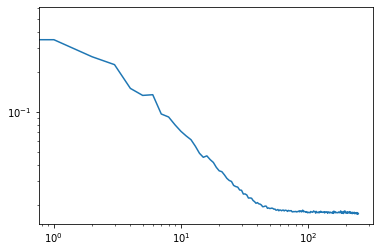

In [373]:
#PLot history
plt.plot(np.array(history.history['loss']))
plt.yscale('log')
plt.xscale('log')

In [393]:
import matplotlib.pyplot as plt

plt.plot(model.predict(x_testn)[0:1,:,:], label="predicted")
#plt.plot(y_testn[0:200], label="true")
plt.title("Predicted values on Test Set")
plt.legend(loc="upper right")

IndexError: ignored

In [0]:
x_testn[0,:,:], y_testn.shape

In [401]:
shape(model.predict(x_testn[0:1]))

(1, 1)

In [410]:
nanmin(history.history["val_loss"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: All-NaN axis encountered
  """Entry point for launching an IPython kernel.


nan

In [0]:
(1 / len(teY)) * np.sum(np.abs((model.predict(teX)[:10000].flatten() - teY.values[:10000]) / teY.values[:10000]))*100

6.855207653967521

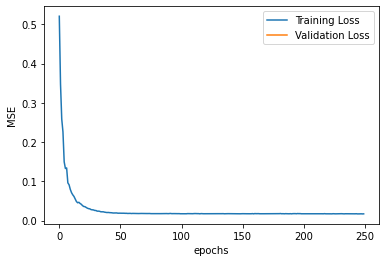

In [404]:
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend()

# data exploration

In [0]:
explore = mydata[["Nepool_Load_Hist"]]
explore2 = mydata[["Nepool_Load_Hist", "KBOS_HID_HIST"]]

In [0]:
mydata.head()

,KBOS_WCL_HIST,KBOS_HID_HIST,Nepool_Load_Hist
Date,,,
2000-01-01 14:00:00,43,47,12849.0
2000-01-01 15:00:00,40,45,12513.0
2000-01-01 16:00:00,39,43,12531.0
2000-01-01 17:00:00,37,41,13706.0
2000-01-01 18:00:00,37,40,15016.0


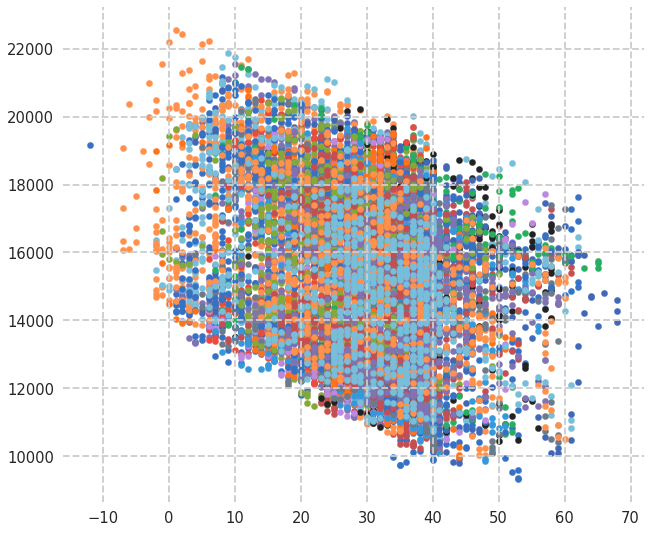

In [0]:
explore.loc[explore.index.year==2010]
y = 2000
while y < 2020:
  try:
     pl.scatter(explore2["KBOS_HID_HIST"].loc[(explore2.index.year==y) & (explore2.index.month==1)].values, explore2["Nepool_Load_Hist"].loc[(explore2.index.year==y) & (explore2.index.month==1)].values, s=40, label="year %s" % y)
  except:
    break
  y += 1

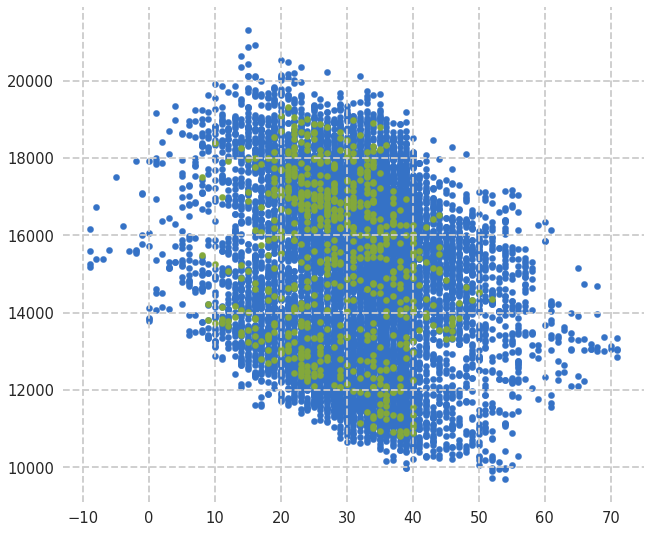

In [0]:
pl.scatter(explore2["KBOS_HID_HIST"].loc[(explore2.index.year!=2014) & (explore2.index.month==2)].values, explore2["Nepool_Load_Hist"].loc[(explore2.index.year!=2014) & (explore2.index.month==2)].values, s=40, label="year %s" % y)
pl.scatter(explore2["KBOS_HID_HIST"].loc[(explore2.index.year==2014) & (explore2.index.month==2)].values, explore2["Nepool_Load_Hist"].loc[(explore2.index.year==2014) & (explore2.index.month==2)].values, s=40, label="year %s" % y)


In [0]:
explore.loc[explore.index.year==2019].values

array([[12131.76],
       [11613.92],
       [11496.66],
       ...,
       [19209.35],
       [17691.34],
       [16197.7 ]])

Text(0.5, 1.0, 'Daily Energy Fluctuations in February, Nepool')

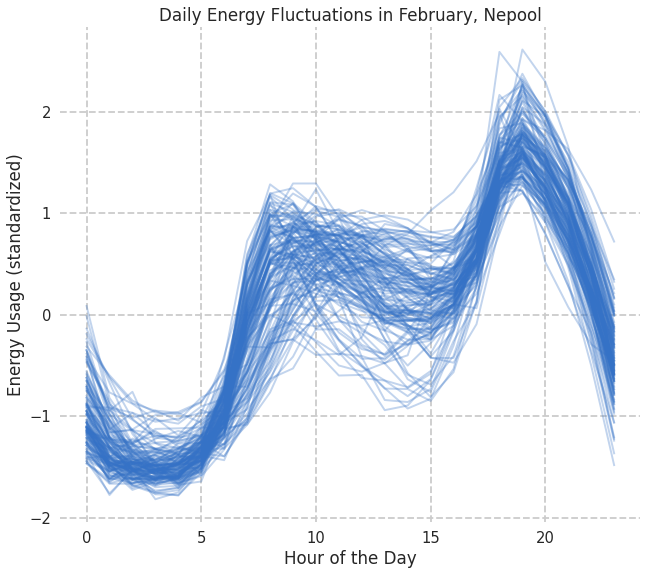

In [0]:
y = 2015
d=1
m=2
while y<2020:
  while d < 32:
    try:
      pl.plot(preprocessing.scale(explore["Nepool_Load_Hist"].loc[(explore.index.year==y) & (explore.index.month==m) & (explore.index.day==d)].values.flatten()), alpha=0.3, c='b')
    except:
      break
    d += 1
  d=1
  y+=1
pl.xlabel("Hour of the Day")
pl.ylabel("Energy Usage (standardized)")
pl.title("Daily Energy Fluctuations in February, Nepool")

Text(0.5, 1.0, 'Daily Energy Fluctuation in July, Nepool')

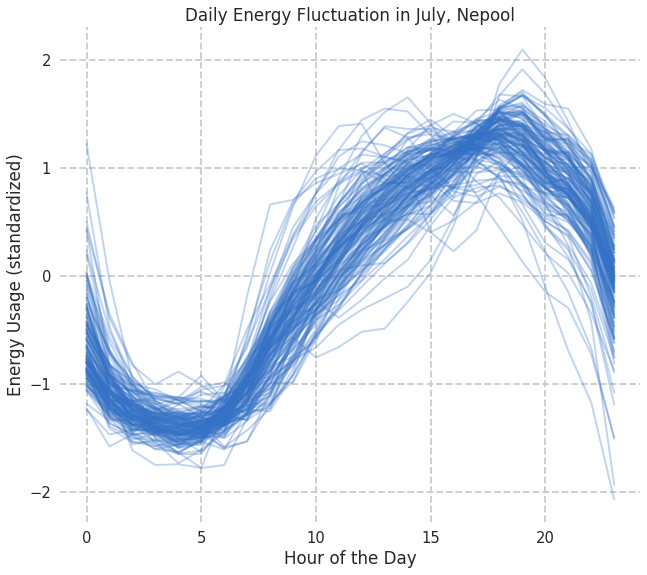

In [0]:
y = 2015
d=1
m = 7
while y<2020:
  while d < 32:
    try:
      pl.plot(preprocessing.scale(explore["Nepool_Load_Hist"].loc[(explore.index.year==y) & (explore.index.month==m) & (explore.index.day==d)].values.flatten()), alpha=0.3, c='b')
    except:
      break
    d += 1
  d=1
  y+=1
pl.xlabel("Hour of the Day")
pl.ylabel("Energy Usage (standardized)")
pl.title("Daily Energy Fluctuation in July, Nepool")

In [0]:
preprocessing.scale(explore["Nepool_Load_Hist"].loc[(explore.index.year==2010) & (explore.index.month==1) & (explore.index.day==2)].values.flatten())

array([-0.71982876, -1.0955258 , -1.34025803, -1.45711216, -1.49371175,
       -1.44785202, -1.2824924 , -0.98131743, -0.66206314, -0.24050637,
        0.16297108,  0.42005016,  0.54307771,  0.56600758,  0.50295045,
        0.45224017,  0.5249984 ,  1.05811778,  1.56742539,  1.51759703,
        1.30946439,  1.08237053,  0.73048527,  0.28291192])

In [0]:
explore["Nepool_Load_Hist"].loc[(explore.index.year==2010) & (explore.index.month==1) & (explore.index.day==2)].values.flatten()

array([12945., 12093., 11538., 11273., 11190., 11294., 11669., 12352.,
       13076., 14032., 14947., 15530., 15809., 15861., 15718., 15603.,
       15768., 16977., 18132., 18019., 17547., 17032., 16234., 15219.])

In [0]:
explore["Nepool_Load_Hist"]

Date
2000-01-01 14:00:00    12849.00
2000-01-01 15:00:00    12513.00
2000-01-01 16:00:00    12531.00
2000-01-01 17:00:00    13706.00
2000-01-01 18:00:00    15016.00
                         ...   
2019-07-28 20:00:00    20403.27
2019-07-28 21:00:00    20008.34
2019-07-28 22:00:00    19209.35
2019-07-28 23:00:00    17691.34
2019-07-29 00:00:00    16197.70
Name: Nepool_Load_Hist, Length: 171562, dtype: float64

In [0]:
import seaborn as sns

In [0]:
for i in range(1, 53):
  explore["Nepool_Load_Hist"].loc[(explore.index.year==2015)])

SyntaxError: ignored

In [0]:
o = explore["Nepool_Load_Hist"].loc[(explore.index.year==2015)].values

In [0]:
o = explore["Nepool_Load_Hist"].loc[(explore.index.year==2016) & (explore.index.week==1)].to_frame()

In [0]:
o['%s' % i] = explore["Nepool_Load_Hist"].loc[(explore.index.year==2016) & (explore.index.week==1)].values

In [0]:
s = explore["Nepool_Load_Hist"].loc[(explore.index.year==2016) & (explore.index.week==1)]

In [0]:
temp = explore["Nepool_Load_Hist"].loc[(explore.index.year==2016) & (explore.index.week==i)]
c = temp.groupby(temp.index.hour).mean()
o = pd.DataFrame({'1':c})

In [0]:

for i in range(2, 52):
  temp = explore["Nepool_Load_Hist"].loc[(explore.index.year==2016) & (explore.index.week==i)]
  c = temp.groupby(temp.index.hour).mean()
  o['%s' % i] = c

In [0]:
for y in range(3):
  if y==0:
    for i in range(2, 53):
      temp = explore["Nepool_Load_Hist"].loc[(explore.index.year==2016) & (explore.index.week==i)]
      c = temp.groupby(temp.index.hour).mean()
      o['%s' % i] = c
  else:
    for i in range(1, 53):
      temp = explore["Nepool_Load_Hist"].loc[(explore.index.year==(2016+y)) & (explore.index.week==i)]
      c = temp.groupby(temp.index.hour).mean()
      o['%s' % (52*y+i)] = c

In [0]:
import seaborn as sns

In [0]:
j = pd.DataFrame(preprocessing.scale(o), columns=o.columns)

In [0]:
j

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
0,-0.939066,-1.178049,-1.196812,-1.087622,-1.157189,-1.139430,-0.956916,-1.120535,-1.100264,-1.214304,-1.127341,-1.112656,-1.186651,-1.017208,-1.112463,-1.146987,-1.131578,-1.160540,-0.999773,-1.106647,-0.819663,-0.775563,-0.830157,-0.885371,-0.796454,-0.750833,-0.619340,-0.787924,-0.714316,-0.624449,-0.805880,-0.766898,-0.711799,-0.710551,-0.799568,-0.878910,-0.968040,-0.842142,-1.032021,-0.970510,-1.054411,-1.052470,-1.044497,-1.166110,-1.088646,-1.124939,-1.054173,-1.057698,-1.119803,-0.939426,-0.939066
1,-1.466260,-1.366737,-1.465221,-1.353321,-1.414369,-1.350555,-1.276048,-1.428286,-1.371497,-1.336727,-1.434238,-1.325512,-1.461071,-1.404040,-1.494366,-1.498691,-1.457014,-1.431705,-1.426183,-1.498815,-1.221973,-1.227895,-1.312225,-1.257540,-1.196796,-1.235596,-1.080724,-1.111170,-1.074465,-1.036063,-1.196949,-1.046426,-1.155654,-1.124372,-1.242398,-1.173485,-1.290469,-1.233574,-1.402979,-1.308469,-1.367912,-1.378171,-1.432372,-1.493810,-1.331255,-1.443938,-1.437055,-1.376484,-1.313241,-1.267269,-1.466260
2,-1.576540,-1.501046,-1.524545,-1.442878,-1.518339,-1.518322,-1.433285,-1.485551,-1.497152,-1.415640,-1.554555,-1.525897,-1.587659,-1.584099,-1.605024,-1.564401,-1.612752,-1.577006,-1.597914,-1.591231,-1.439682,-1.447856,-1.533153,-1.417918,-1.366372,-1.396916,-1.302463,-1.269355,-1.232216,-1.219249,-1.306978,-1.208013,-1.298281,-1.267402,-1.354275,-1.386332,-1.401057,-1.440424,-1.556984,-1.480826,-1.487464,-1.455007,-1.579529,-1.600001,-1.471997,-1.532613,-1.600891,-1.508287,-1.399634,-1.465704,-1.576540
3,-1.582868,-1.604472,-1.544429,-1.589902,-1.605623,-1.601810,-1.570586,-1.522717,-1.566347,-1.556140,-1.603516,-1.617718,-1.665670,-1.635403,-1.697911,-1.580476,-1.638743,-1.620913,-1.638217,-1.616871,-1.511595,-1.525695,-1.615192,-1.487675,-1.420995,-1.448332,-1.439269,-1.376708,-1.348973,-1.311666,-1.354193,-1.330144,-1.317159,-1.326837,-1.415659,-1.470605,-1.446854,-1.492879,-1.589833,-1.582084,-1.541606,-1.560003,-1.625134,-1.576869,-1.493306,-1.565340,-1.541771,-1.548275,-1.504718,-1.553337,-1.582868
4,-1.503435,-1.575407,-1.482004,-1.621164,-1.628162,-1.607179,-1.553620,-1.520563,-1.591889,-1.567609,-1.644221,-1.597352,-1.630258,-1.707172,-1.631926,-1.596273,-1.625595,-1.607456,-1.656914,-1.638137,-1.555250,-1.577285,-1.601771,-1.487466,-1.426711,-1.457024,-1.533938,-1.443747,-1.421238,-1.428110,-1.385099,-1.410132,-1.391009,-1.369106,-1.452665,-1.519783,-1.444126,-1.554409,-1.613070,-1.636712,-1.547133,-1.625131,-1.651996,-1.540566,-1.446624,-1.541993,-1.495859,-1.490773,-1.509595,-1.578616,-1.503435
5,-1.376957,-1.401934,-1.310564,-1.416159,-1.444633,-1.438011,-1.383165,-1.301521,-1.392323,-1.342626,-1.559787,-1.490755,-1.461949,-1.570493,-1.449418,-1.404440,-1.442143,-1.504103,-1.570208,-1.539170,-1.501831,-1.487428,-1.535778,-1.443797,-1.388807,-1.429054,-1.516648,-1.429240,-1.421804,-1.446838,-1.349748,-1.386396,-1.360640,-1.419564,-1.425572,-1.458016,-1.430621,-1.493119,-1.480545,-1.540902,-1.447441,-1.504471,-1.474697,-1.463024,-1.276255,-1.371363,-1.406016,-1.336326,-1.334246,-1.471666,-1.376957
6,-1.014077,-1.076209,-1.024174,-0.891446,-0.995857,-1.066065,-1.044676,-0.984914,-0.880484,-0.862923,-1.108571,-1.093018,-1.076110,-1.102370,-0.946196,-1.042913,-1.067107,-1.195157,-1.186095,-1.174300,-1.339191,-1.327738,-1.275980,-1.333543,-1.322413,-1.385981,-1.373191,-1.369454,-1.338330,-1.353397,-1.281269,-1.273604,-1.252748,-1.319801,-1.306479,-1.224964,-1.214370,-1.201158,-1.213849,-1.227228,-1.116779,-1.225817,-1.070623,-0.949721,-0.895770,-0.909683,-1.093832,-0.984680,-0.937475,-1.088687,-1.014077
7,-0.311308,-0.247017,-0.303468,-0.048199,-0.201912,-0.346752,-0.229811,-0.189209,-0.085142,-0.093765,-0.145774,-0.208588,-0.319091,-0.078464,0.036889,-0.570703,-0.428796,-0.520237,-0.443945,-0.505084,-0.838879,-0.876367,-0.804800,-0.924032,-1.069570,-1.044743,-1.054801,

[Text(65.50000000000001, 0.5, 'week'), Text(0.5, 53.8, 'hour')]

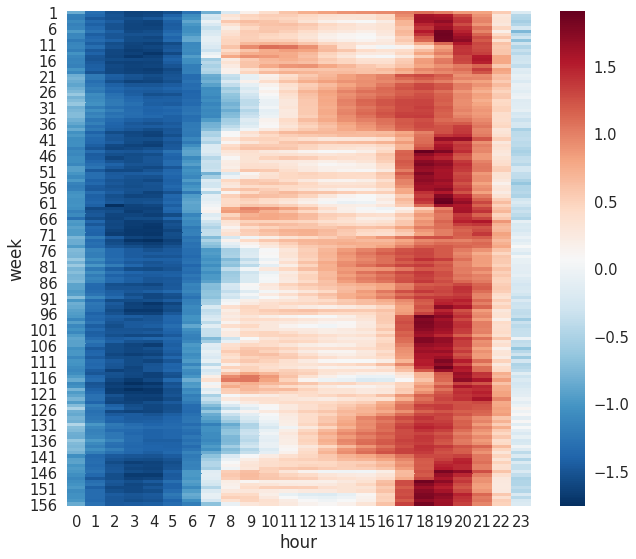

In [0]:
ax = sns.heatmap(j.T, cmap="RdBu_r")
ax.set(xlabel="hour", ylabel="week")

In [0]:
o

,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,12194.30,11929.55,12733.24,13103.76,11679.22,12433.42,15942.37,11633.01,11432.00,11294.78,12240.50,11085.00,12684.34,11233.96,10761.18,10295.61,10625.50,10439.11,10311.87,11810.28,11520.66,10746.14,12364.29,13258.42,12468.91,11832.85,15966.04,15849.62,13793.80,14694.84,18040.17,15365.76,14429.96,11386.90,12410.96,13679.83,10391.58,10656.00,10890.30,10415.48,10838.82,10849.98,10901.73,11686.88,11838.22,12624.38,13200.40,13559.08
1,11764.46,11644.48,12451.31,12966.59,11317.41,12320.91,15522.79,11092.21,11444.87,10737.49,12132.53,11093.51,12339.36,10853.78,10608.27,9992.74,10323.18,10070.66,10084.05,10946.70,10866.40,10245.30,11646.82,12374.01,11522.51,11149.31,14811.58,14761.33,13370.56,13844.96,16924.07,14383.72,13754.99,10756.00,11686.93,12975.92,9841.80,10508.96,10541.42,10173.38,10300.29,10672.74,10435.76,11305.02,11438.02,12678.95,13047.44,13107.68
2,11433.47,11385.48,12453.53,12920.12,11402.32,12222.43,15372.46,11128.44,11146.11,10329.40,11915.24,10812.89,12136.18,10897.29,10616.23,10153.21,10151.30,9917.62,9859.49,10566.65,10537.22,10137.36,11391.30,12117.98,10862.70,10696.80,14692.08,14193.87,13211.52,13225.90,16537.68,14155.04,13775.90,10076.55,11520.36,12677.43,9482.51,10183.37,10157.22,9899.06,9930.48,10497.37,10185.64,11205.33,11281.34,12547.09,12834.21,13251.30
3,11317.34,11324.93,12319.78,12851.68,11269.17,12094.89,15321.47,11148.12,11017.52,10388.30,11610.84,10875.61,11983.06,10794.91,10472.38,10324.12,10301.96,10008.44,9706.57,10501.78,10412.24,10250.88,11221.58,11976.02,10415.50,10411.51,14423.22,13866.97,13297.00,12993.51,16493.59,14050.78,13524.10,9786.39,11305.20,12645.56,9425.79,10007.65,10123.02,9754.22,9765.85,10672.58,10326.83,11334.40,11545.97,12397.49,12762.11,13268.01
4,11421.11,11433.44,12579.65,12867.38,11316.82,12177.30,15351.17,11223.46,11158.70,10459.62,11597.91,10949.15,11587.42,10812.78,10471.37,10458.36,10518.33,10063.36,9741.51,10602.25,10323.56,10367.39,11354.29,11843.58,10167.99,10351.99,14473.81,13339.51,13162.48,13026.56,16224.15,13852.20,13379.29,9877.56,11376.58,12583.25,9580.54,9994.90,10060.27,9748.89,9744.44,10789.68,10441.32,11435.94,11759.17,12438.91,12816.22,13376.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,15605.88,16485.20,16707.52,15475.08,15994.85,19561.96,15249.04,15104.00,15677.20,14338.22,12181.20,14250.33,13159.98,12170.69,12309.29,13499.65,12095.72,12599.96,12790.06,14543.90,13401.46,15693.20,17271.84,14933.68,14703.62,20409.44,20477.72,16986.30,18913.24,23747.26,18939.91,18996.63,14084.66,16850.74,17064.82,13479.14,14038.00,13890.62,14170.90,14104.54,14362.31,14680.71,15593.90,15857.41,16497.53,17662.59,16843.99,14586.86
20,15020.70,15968.96,16669.40,15063.50,15265.44,19180.79,14916.24,14823.30,15547.01,15039.76,13319.53,15048.30,13911.71,12638.80,12796.35,13707.68,12465.82,12786.78,12909.56,14498.92,13300.66,15322.94,16838.97,14572.17,14548.76,19918.54,19934.77,16857.84,18383.59,23145.82,18841.66,18655.48,14192.33,16741.89,17532.26,13938.87,14077.71,13762.87,14103.49,13960.10,14022.13,14213.67,15164.85,15396.41,16174.78,17250.79,16582.38,14570.88
21,14301.57,15491.92,16042.36,14467.26,14754.61,18650.16,14342.59,14256.40,15059.16,14736.53,13567.82,15153.46,14190.54,12998.97,13194.92,13700.44,13071.30,13117.91,13235.00,14444.71,13353.44,15189.77,16480.58,14342.00,14497.87,19612.98,19527.58,16864.44,18169.40,22785.75,18859.33,18449.19,14049.85,16173.34,17065.84,13361.03,13464.56,13214.48,13489.88,13515.88,13410.29,13690.42,14664.40,14939.53,15645.99,16645.92,16196.53,14510.38


In [0]:
o.head()

,Nepool_Load_Hist,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04 00:00:00,12194.30,11929.55,12733.24,13103.76,11679.22,12433.42,15942.37,11633.01,11432.00,11294.78,12240.50,11085.00,12684.34,11233.96,10761.18,10295.61,10625.50,10439.11,10311.87,11810.28,11520.66,10746.14,12364.29,13258.42,12468.91,11832.85,15966.04,15849.62,13793.80,14694.84,18040.17,15365.76,14429.96,11386.90,12410.96,13679.83,10391.58,10656.00,10890.30,10415.48,10838.82,10849.98,10901.73,11686.88,11838.22,12624.38,13200.40,13559.08
2016-01-04 01:00:00,11764.46,11644.48,12451.31,12966.59,11317.41,12320.91,15522.79,11092.21,11444.87,10737.49,12132.53,11093.51,12339.36,10853.78,10608.27,9992.74,10323.18,10070.66,10084.05,10946.70,10866.40,10245.30,11646.82,12374.01,11522.51,11149.31,14811.58,14761.33,13370.56,13844.96,16924.07,14383.72,13754.99,10756.00,11686.93,12975.92,9841.80,10508.96,10541.42,10173.38,10300.29,10672.74,10435.76,11305.02,11438.02,12678.95,13047.44,13107.68
2016-01-04 02:00:00,11433.47,11385.48,12453.53,12920.12,11402.32,12222.43,15372.46,11128.44,11146.11,10329.40,11915.24,10812.89,12136.18,10897.29,10616.23,10153.21,10151.30,9917.62,9859.49,10566.65,10537.22,10137.36,11391.30,12117.98,10862.70,10696.80,14692.08,14193.87,13211.52,13225.90,16537.68,14155.04,13775.90,10076.55,11520.36,12677.43,9482.51,10183.37,10157.22,9899.06,9930.48,10497.37,10185.64,11205.33,11281.34,12547.09,12834.21,13251.30
2016-01-04 03:00:00,11317.34,11324.93,12319.78,12851.68,11269.17,12094.89,15321.47,11148.12,11017.52,10388.30,11610.84,10875.61,11983.06,10794.91,10472.38,10324.12,10301.96,10008.44,9706.57,10501.78,10412.24,10250.88,11221.58,11976.02,10415.50,10411.51,14423.22,13866.97,13297.00,12993.51,16493.59,14050.78,13524.10,9786.39,11305.20,12645.56,9425.79,10007.65,10123.02,9754.22,9765.85,10672.58,10326.83,11334.40,11545.97,12397.49,12762.11,13268.01
2016-01-04 04:00:00,11421.11,11433.44,12579.65,12867.38,11316.82,12177.30,15351.17,11223.46,11158.70,10459.62,11597.91,10949.15,11587.42,10812.78,10471.37,10458.36,10518.33,10063.36,9741.51,10602.25,10323.56,10367.39,11354.29,11843.58,10167.99,10351.99,14473.81,13339.51,13162.48,13026.56,16224.15,13852.20,13379.29,9877.56,11376.58,12583.25,9580.54,9994.90,10060.27,9748.89,9744.44,10789.68,10441.32,11435.94,11759.17,12438.91,12816.22,13376.09
